<a href="https://colab.research.google.com/github/youhangkai/SHARING/blob/main/GOES_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 

In [ ]:
import geemap
import ee

In [ ]:
figure1 = geemap.Map()
figure1.add_basemap('OpenTopoMap')
cam = ee.Geometry.Polygon(
        [
              [
                [-77,7],
                [-77,20],
                [-100,20],
                [-100,7],
                [-77,7]
              ]
        ],
        None,
        False,
    )
    
figure1.addLayer(cam, {}, "Central America")
figure1.centerObject(cam,4)

figure1

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=qKQ8nvBs9fGUYmgVzmkEnk9py21mi1xblhfSiNTmwus&tc=mHEcZ53n4i2M0E8a2WvUAADLmeY6YEfW6J9iFhefKkk&cc=IETEKe_Efh7t7JbLitEXY-5TyQHVsEw141aU_ZrBfkk

The authorization workflow will generate a code, which you should paste in the box below.


KeyboardInterrupt: ignored

In [ ]:
!pip install netCDF4 numpy
!pip install goes16ci
!pip install pyproj
import netCDF4 as nc
from google.cloud import storage
import netCDF4 as nc
import numpy as np
from pyproj import Proj, transform
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()
    
    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)

    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    # Calculate the indices for slicing the arrays
    height, width = R_full.shape
    y_start, y_end = int(height * 0.3), int(height * 0.55)
    x_start, x_end = int(width * 0.3), int(width * 0.55)

    # Slice the arrays
    R[day_str] = R_full[y_start:y_end, x_start:x_end]
    NIR[day_str] = NIR_full[y_start:y_end, x_start:x_end]

    gamma = 1.5
    R[day_str] = np.power(R[day_str], 1/gamma)
    NIR[day_str] = np.power(NIR[day_str], 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()

    return NDVI[day_str]


start_day = 1
end_day = 366
NDVI = {}
NDVI_diff = {}
mean_ndvi = {}
for day in range(start_day, end_day):
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
  # if day in [241, 256, 321, 335]:
        print('skipped', day)
        mean_ndvi[day] = np.nan
        continue
        # missing data here
  day_str = str(day).zfill(3)
  NDVI = fetch_and_process_data(day_str)
  mean_ndvi[day] = np.mean(NDVI)
  print(['finished '+str(day)])

['finished 1']
['finished 2']
['finished 3']
skipped 4
['finished 5']
['finished 6']
['finished 7']
['finished 8']
['finished 9']
['finished 10']
['finished 11']
['finished 12']
['finished 13']
['finished 14']
['finished 15']
['finished 16']
['finished 17']
['finished 18']
['finished 19']
['finished 20']
['finished 21']
['finished 22']
['finished 23']
['finished 24']
['finished 25']
['finished 26']
['finished 27']
['finished 28']
['finished 29']
['finished 30']
['finished 31']
['finished 32']
['finished 33']
['finished 34']
['finished 35']
['finished 36']
['finished 37']
['finished 38']
['finished 39']
['finished 40']
['finished 41']
['finished 42']
['finished 43']
['finished 44']
['finished 45']
['finished 46']
['finished 47']
['finished 48']
['finished 49']
['finished 50']
['finished 51']
['finished 52']
['finished 53']
['finished 54']
['finished 55']
['finished 56']
['finished 57']
['finished 58']
['finished 59']
['finished 60']
['finished 61']
['finished 62']
['finished 63']
skippe

In [ ]:
mean_ndvi

{1: 0.5279696665470252,
 2: 0.5172774409793633,
 3: 0.5406821995805458,
 4: nan,
 5: 0.5377288613837432,
 6: 0.5375362887252187,
 7: 0.5429679654167098,
 8: 0.5330922366535606,
 9: 0.5300029477011867,
 10: 0.5401774825077159,
 11: 0.5295545358018665,
 12: 0.5307193912445425,
 13: 0.5326981759509707,
 14: 0.5259629334927612,
 15: 0.5297675849337119,
 16: 0.5310702641423555,
 17: 0.5339626230137551,
 18: 0.5291354059204227,
 19: 0.5228763994689878,
 20: 0.5214331236524062,
 21: 0.5247732265462925,
 22: 0.5195391324291151,
 23: 0.5184885022385023,
 24: 0.5132707609571339,
 25: 0.521556899625294,
 26: 0.5139444004748714,
 27: 0.5095209925476926,
 28: 0.5129331010747581,
 29: 0.5232963344796367,
 30: 0.5184378260052034,
 31: 0.5178484211360028,
 32: 0.5095221211086789,
 33: 0.5015528135969464,
 34: 0.51021578935059,
 35: 0.49959615743038965,
 36: 0.5089711586107081,
 37: 0.4954532146911051,
 38: 0.508904068351614,
 39: 0.508787792624371,
 40: 0.5094891704557462,
 41: 0.496208201611826,
 42:

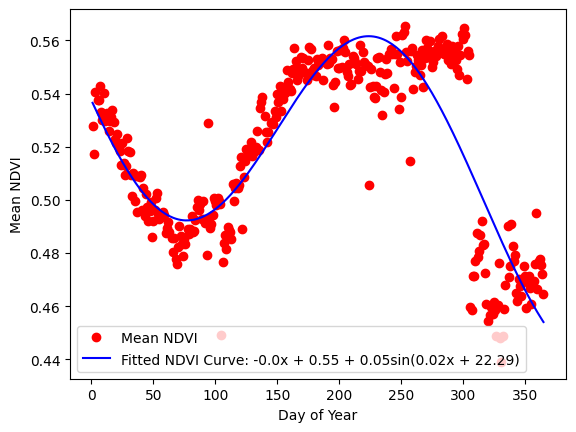

f(x) = -0.00016491307078603937 * x + 0.551728819660885 + 0.04757909370991294 * sin(0.018870513168321803 * x + 22.29417508254667)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a function that combines a linear equation and a sine function
def linear_sine(x, a, b, c, d, e):
    return a * x + b + c * np.sin(d * x + e)

# Create a list of days to exclude
exclude_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]
start_day = 1
end_day = 366

my_array = np.array(list(mean_ndvi.values()))
mean_ndvi_values = my_array
# Create a new list that includes only the non-NaN values
mean_ndvi_values = mean_ndvi_values[~np.isnan(mean_ndvi_values)]

array = [range(1,4),range(5,64),range(65,77),range(78,139),range(140,144),range(145,241),range(242,256),range(257,321),range(322,335),range(336,366)]
# array = [range(230,241),range(242,256),range(257,321),range(322,335),range(336,366)]

# Concatenate all ranges into a single array
x = np.concatenate(array)


# Fit the linear sine function to the non-NaN values
popt, pcov = curve_fit(linear_sine, x, mean_ndvi_values, p0=[0,0.001,0.00001,0.000001,0.01])

# Plot the original mean NDVI data and the fitted linear sine curve
plt.plot(x, mean_ndvi_values, 'ro', label='Mean NDVI')
plt.plot(x, linear_sine(x, *popt), 'b-', label='Fitted NDVI Curve: {}x + {} + {}sin({}x + {})'.format(round(popt[0],2), round(popt[1],2), round(popt[2],2), round(popt[3],2), round(popt[4],2)))
plt.xlabel('Day of Year')
plt.ylabel('Mean NDVI')
plt.legend()
plt.show()
print("f(x) = {} * x + {} + {} * sin({} * x + {})".format(*popt))


Read ABI-L2-BRFF_2022_002_18_OR_ABI-L2-BRFF-M6_G17_s20220021800321_e20220021809388_c20220021811078.nc
Read ABI-L2-BRFF_2022_003_18_OR_ABI-L2-BRFF-M6_G17_s20220031800321_e20220031809388_c20220031811083.nc
skipped 4
Read ABI-L2-BRFF_2022_005_18_OR_ABI-L2-BRFF-M6_G17_s20220051800321_e20220051809388_c20220051811094.nc


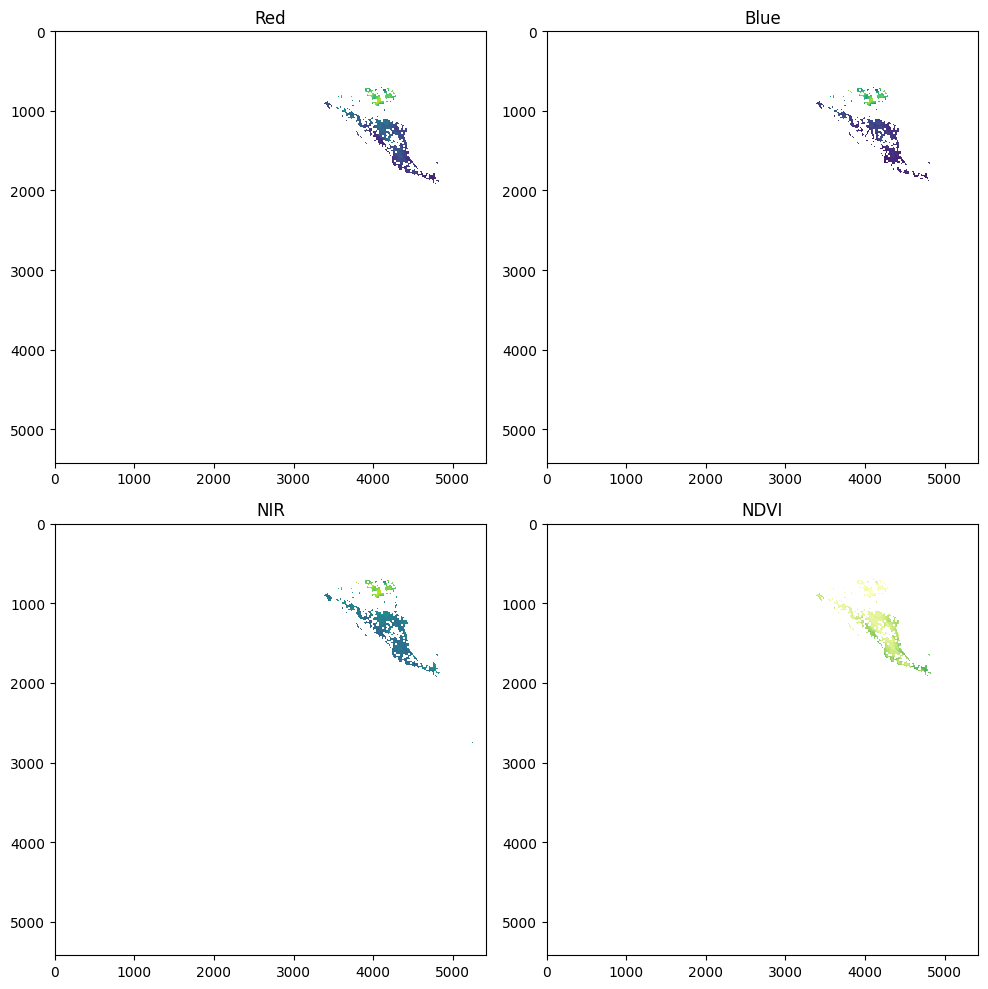

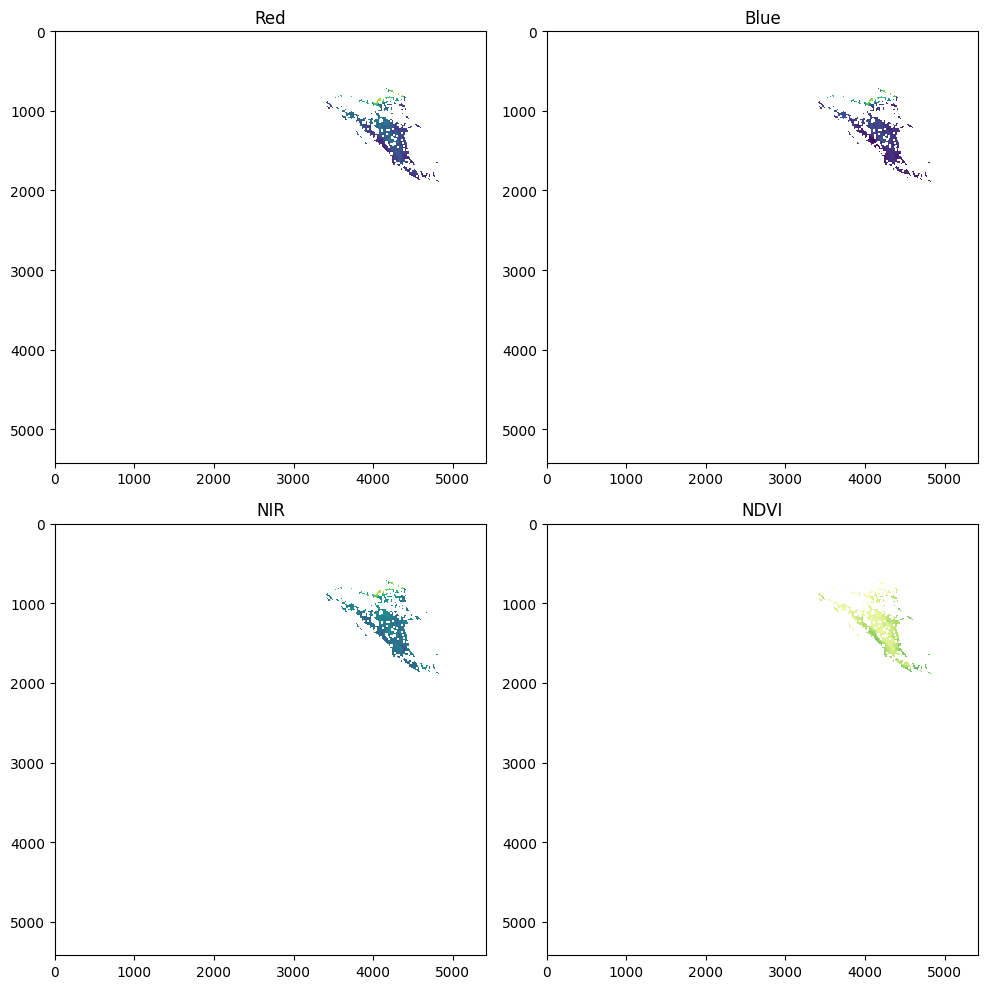

skipped 4


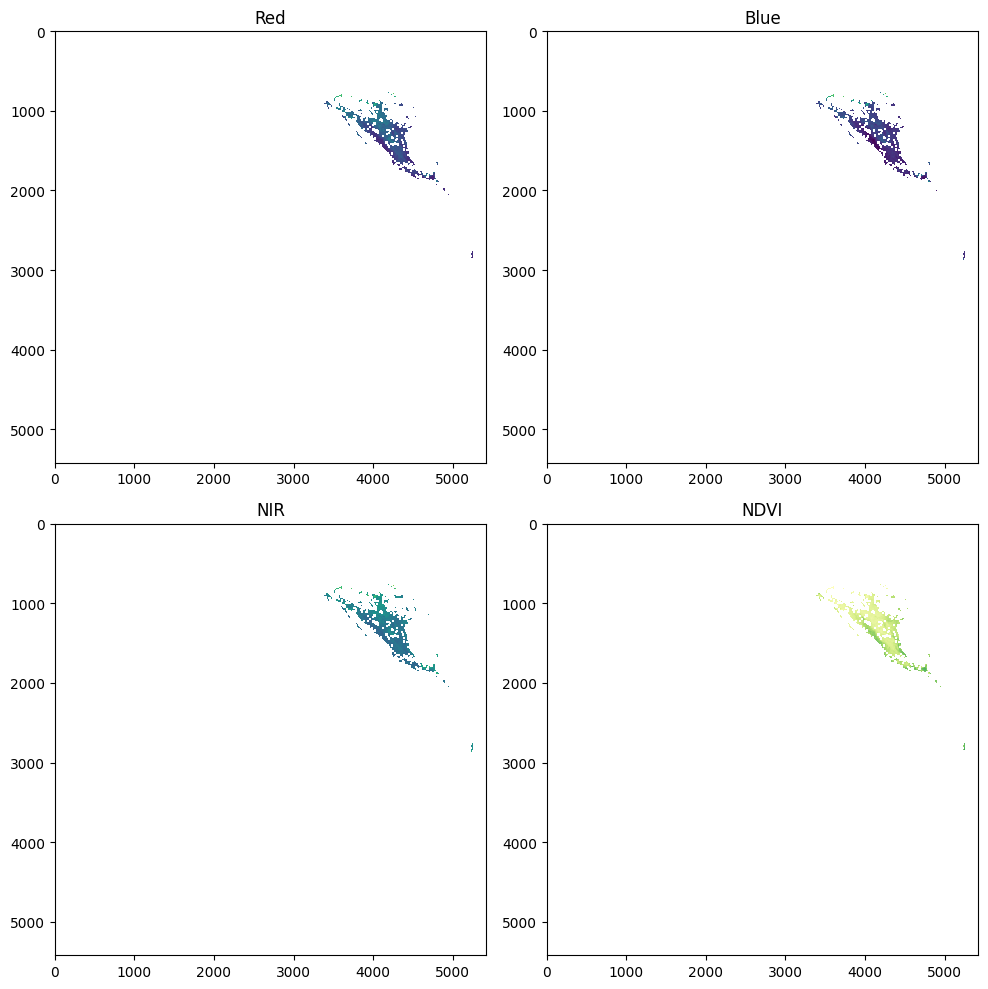

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '17'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '18'
storage_client = storage.Client.create_anonymous_client()

for day in range(2, 6):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)
        
        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA) 
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(2, 6):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
  axs[0, 0].imshow(R[f'{day_str}'])
  axs[0, 0].set_title('Red')
  axs[0, 1].imshow(B[f'{day_str}'])
  axs[0, 1].set_title('Blue')
  axs[1, 0].imshow(NIR[f'{day_str}'])
  axs[1, 0].set_title('NIR')
  axs[1, 1].imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  axs[1, 1].set_title('NDVI')
  fig.tight_layout()
  plt.show()


Read ABI-L2-BRFF_2022_020_18_OR_ABI-L2-BRFF-M6_G17_s20220201800321_e20220201809388_c20220201811011.nc
Read ABI-L2-BRFF_2022_021_18_OR_ABI-L2-BRFF-M6_G17_s20220211800321_e20220211809388_c20220211811190.nc
Read ABI-L2-BRFF_2022_022_18_OR_ABI-L2-BRFF-M6_G17_s20220221800321_e20220221809388_c20220221811110.nc
Read ABI-L2-BRFF_2022_023_18_OR_ABI-L2-BRFF-M6_G17_s20220231800321_e20220231809388_c20220231811079.nc
Read ABI-L2-BRFF_2022_024_18_OR_ABI-L2-BRFF-M6_G17_s20220241800321_e20220241809388_c20220241811262.nc
Read ABI-L2-BRFF_2022_025_18_OR_ABI-L2-BRFF-M6_G17_s20220251800321_e20220251809388_c20220251810563.nc


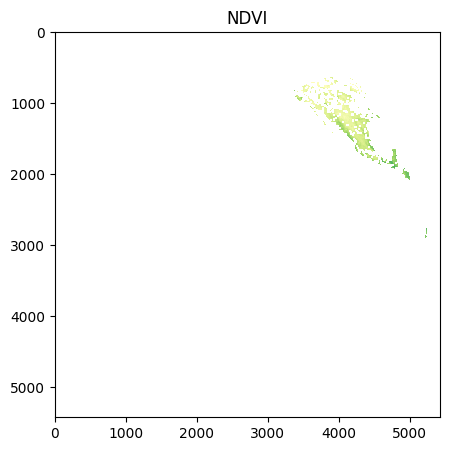

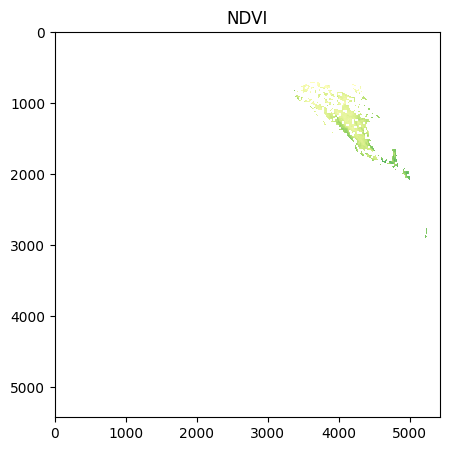

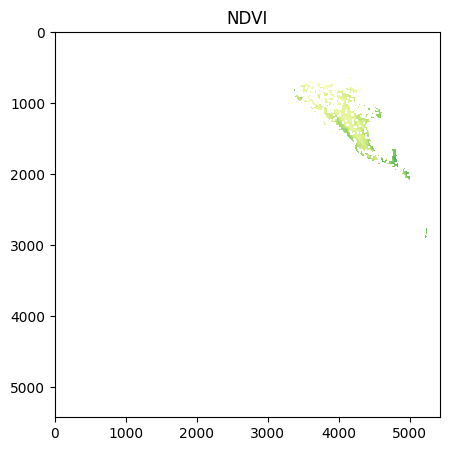

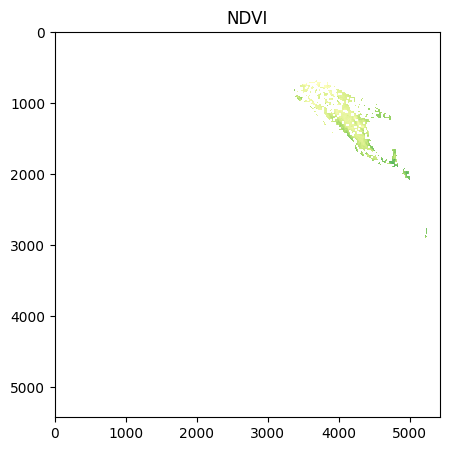

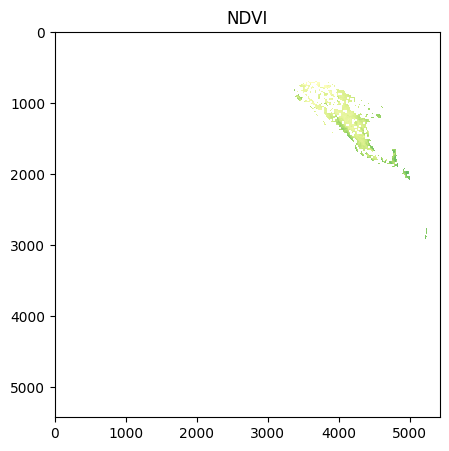

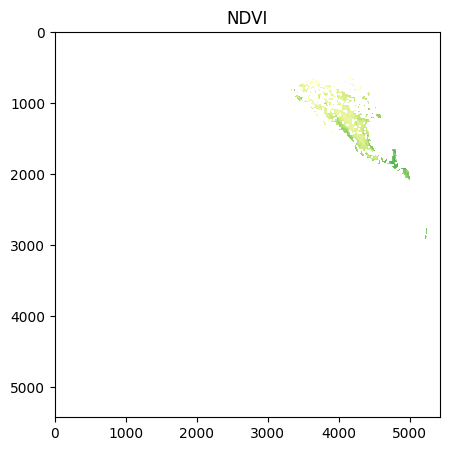

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '17'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '18'
storage_client = storage.Client.create_anonymous_client()

for day in range(20, 26):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)
        
        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA) 
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(20, 26):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
  ax.imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  ax.set_title('NDVI')
  plt.show()



Read ABI-L2-BRFF_2022_090_18_OR_ABI-L2-BRFF-M6_G17_s20220901800321_e20220901809388_c20220901810533.nc
Read ABI-L2-BRFF_2022_091_18_OR_ABI-L2-BRFF-M6_G17_s20220911800321_e20220911809388_c20220911811154.nc
Read ABI-L2-BRFF_2022_092_18_OR_ABI-L2-BRFF-M6_G17_s20220921800321_e20220921809388_c20220921811013.nc
Read ABI-L2-BRFF_2022_093_18_OR_ABI-L2-BRFF-M6_G17_s20220931800321_e20220931809388_c20220931811094.nc
Read ABI-L2-BRFF_2022_094_18_OR_ABI-L2-BRFF-M6_G17_s20220941800321_e20220941809387_c20220941810585.nc
Read ABI-L2-BRFF_2022_095_18_OR_ABI-L2-BRFF-M6_G17_s20220951800321_e20220951809388_c20220951811192.nc
Read ABI-L2-BRFF_2022_096_18_OR_ABI-L2-BRFF-M6_G17_s20220961800321_e20220961809388_c20220961810567.nc
Read ABI-L2-BRFF_2022_097_18_OR_ABI-L2-BRFF-M6_G17_s20220971800321_e20220971809388_c20220971811073.nc
Read ABI-L2-BRFF_2022_098_18_OR_ABI-L2-BRFF-M6_G17_s20220981800321_e20220981809388_c20220981811067.nc
Read ABI-L2-BRFF_2022_099_18_OR_ABI-L2-BRFF-M6_G17_s20220991800321_e20220991809388

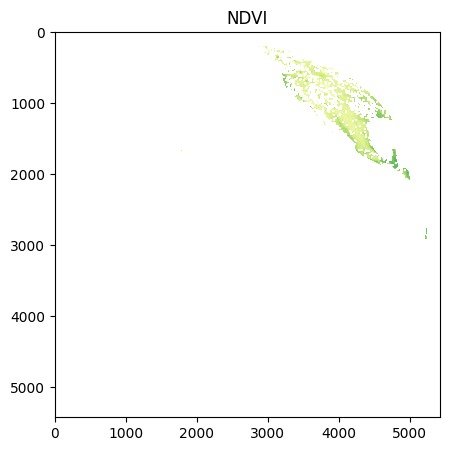

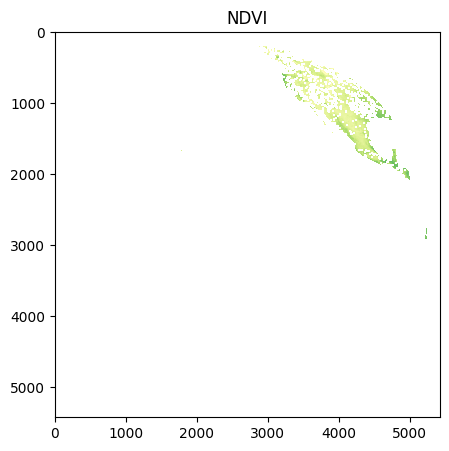

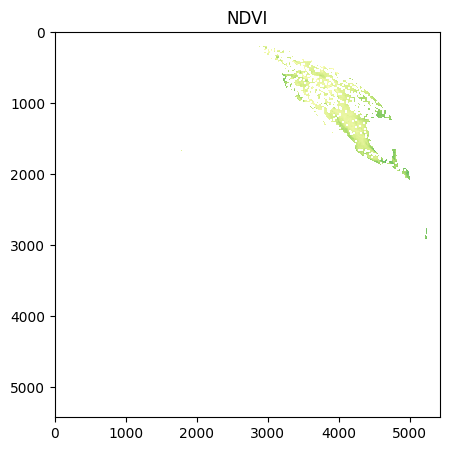

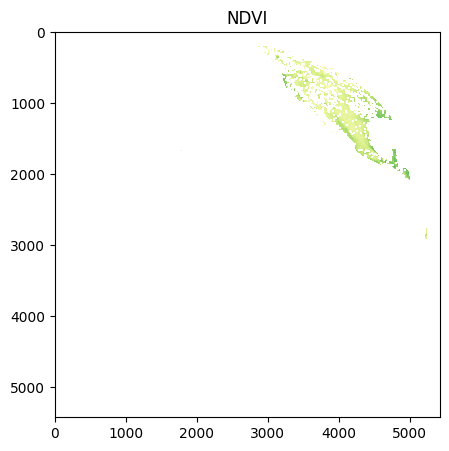

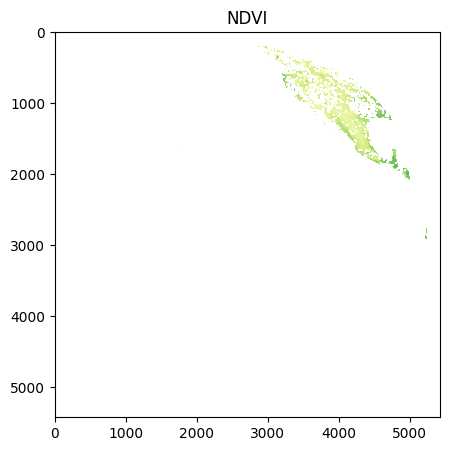

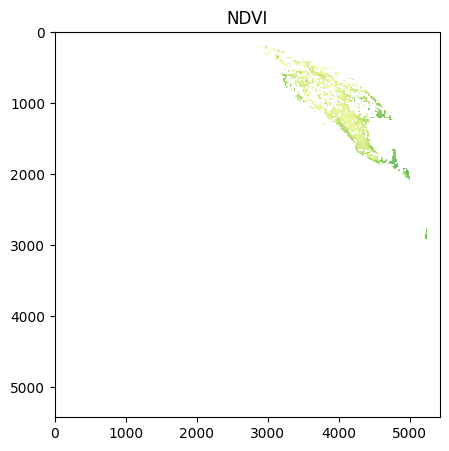

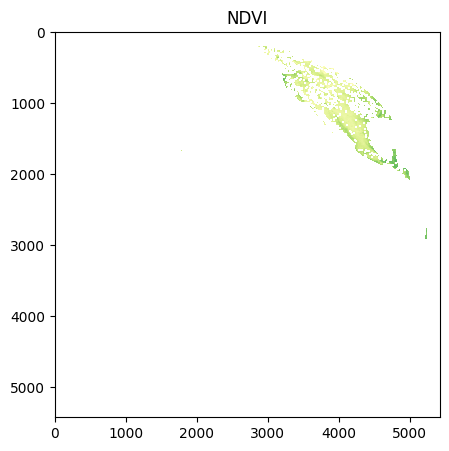

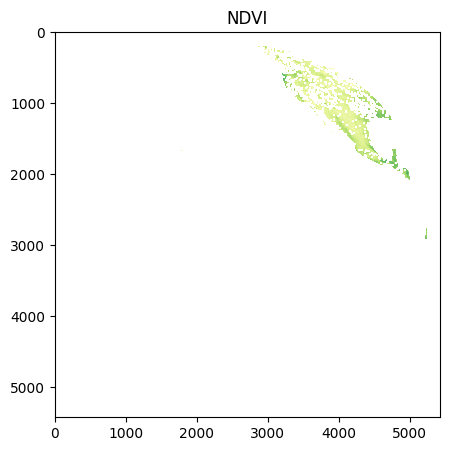

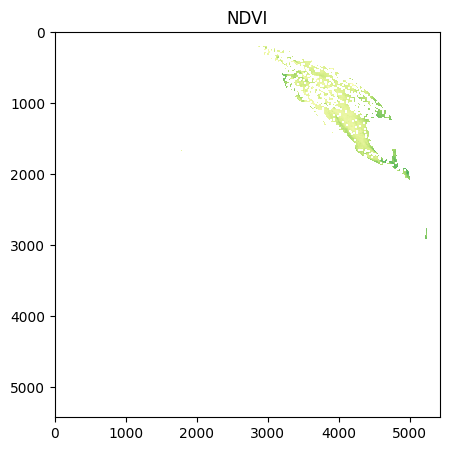

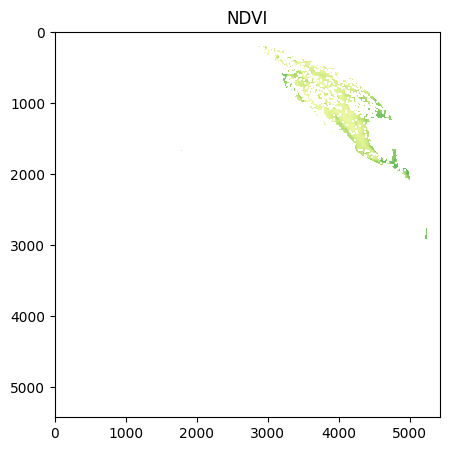

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '17'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '18'
storage_client = storage.Client.create_anonymous_client()

for day in range(90, 100):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)
        
        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA) 
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(90, 100):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
  ax.imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  ax.set_title('NDVI')
  plt.show()


Read ABI-L2-BRFF_2022_090_16_OR_ABI-L2-BRFF-M6_G17_s20220901600321_e20220901609388_c20220901611008.nc
Read ABI-L2-BRFF_2022_091_16_OR_ABI-L2-BRFF-M6_G17_s20220911600321_e20220911609388_c20220911611104.nc
Read ABI-L2-BRFF_2022_092_16_OR_ABI-L2-BRFF-M6_G17_s20220921600321_e20220921609388_c20220921611000.nc
Read ABI-L2-BRFF_2022_093_16_OR_ABI-L2-BRFF-M6_G17_s20220931600321_e20220931609388_c20220931610562.nc
Read ABI-L2-BRFF_2022_094_16_OR_ABI-L2-BRFF-M6_G17_s20220941600321_e20220941609388_c20220941610535.nc
Read ABI-L2-BRFF_2022_095_16_OR_ABI-L2-BRFF-M6_G17_s20220951600321_e20220951609388_c20220951610566.nc
Read ABI-L2-BRFF_2022_096_16_OR_ABI-L2-BRFF-M6_G17_s20220961600321_e20220961609387_c20220961610473.nc
Read ABI-L2-BRFF_2022_097_16_OR_ABI-L2-BRFF-M6_G17_s20220971600321_e20220971609388_c20220971611005.nc
Read ABI-L2-BRFF_2022_098_16_OR_ABI-L2-BRFF-M6_G17_s20220981600321_e20220981609388_c20220981611108.nc
Read ABI-L2-BRFF_2022_099_16_OR_ABI-L2-BRFF-M6_G17_s20220991600321_e20220991609388

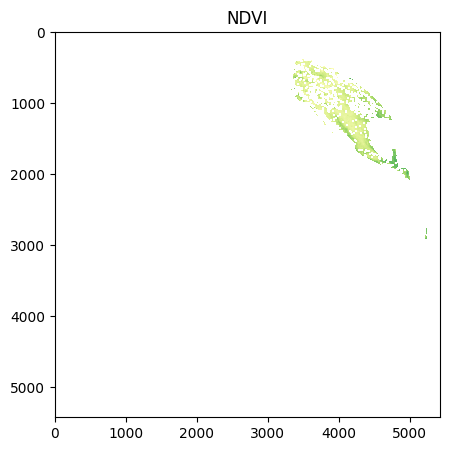

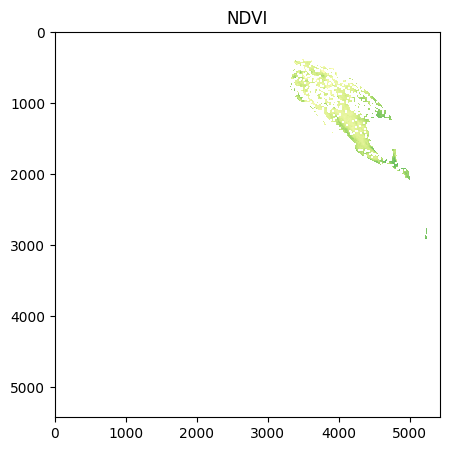

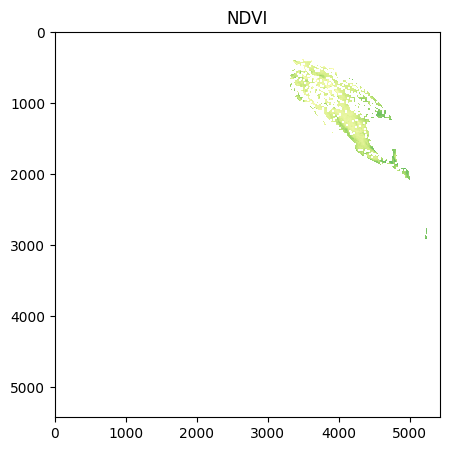

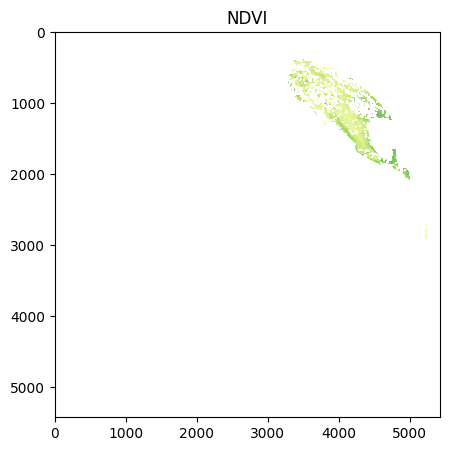

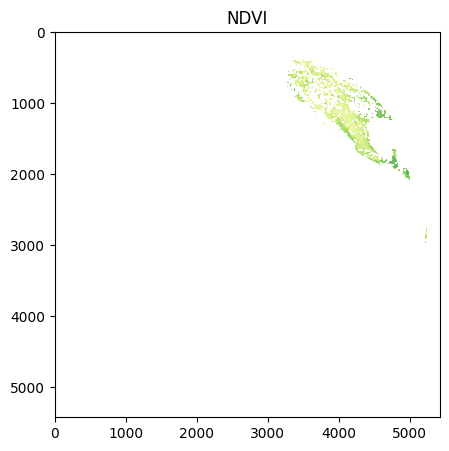

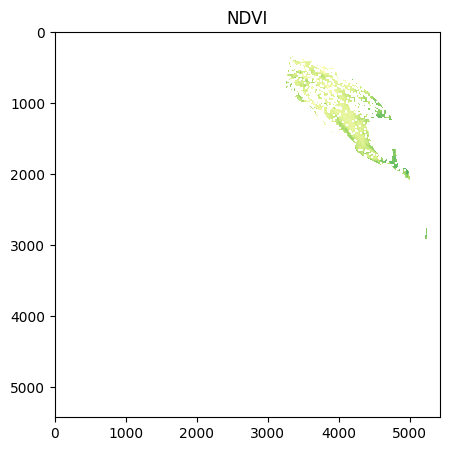

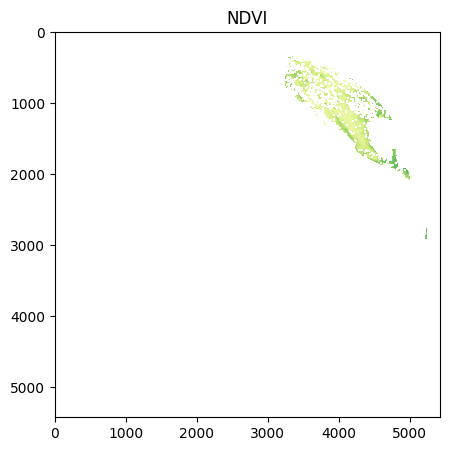

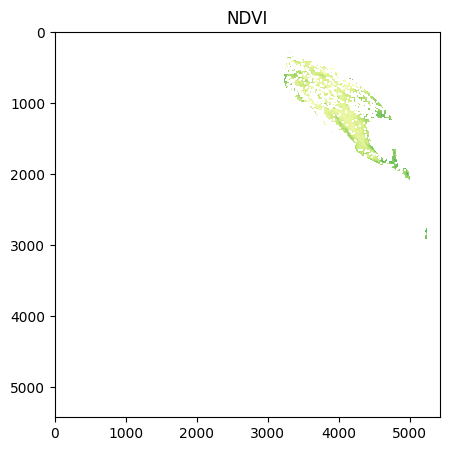

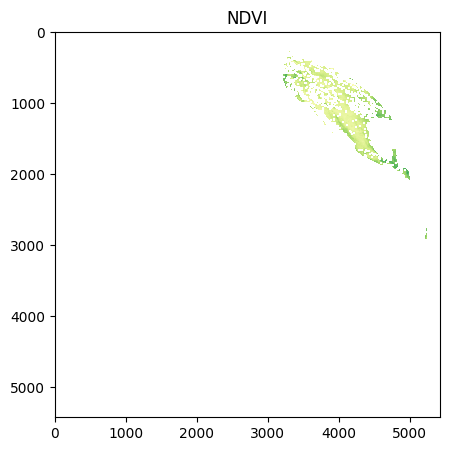

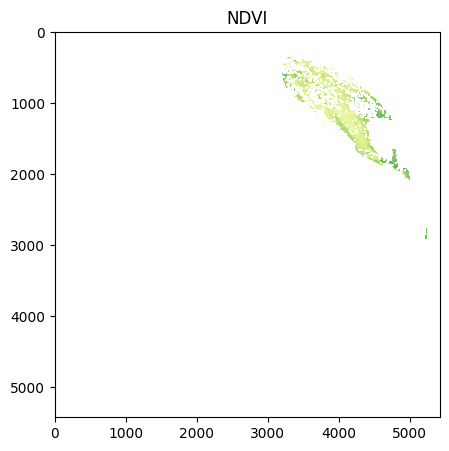

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '17'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '16'
storage_client = storage.Client.create_anonymous_client()

for day in range(90, 100):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)
        
        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA) 
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(90, 100):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
  ax.imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  ax.set_title('NDVI')
  plt.show()
